In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm_vae1cell import *
import torch
import random
from config import *
import sys
sys.path.append('../esa')
from esa.load_utils import *
from esa.lstm_utils import *

from omegaconf import OmegaConf
from notebook_utils import launch_train_advice

import numpy as np

architecture = 'lstm_vae1cell'
os.environ['architecture'] = architecture
config_file = os.path.join(conf_path, architecture+'.yaml')
cfg = OmegaConf.load(config_file)
cfg.dataset.out_window = cfg.dataset.sequence_length

In [2]:
if os.path.exists(model_results+ '{}/'.format(architecture)):
    model_list = os.listdir(model_results+ '{}/'.format(architecture))
    for ix, mn in enumerate(model_list):  
        print('model num {}: {}'.format(ix,model_list[ix]))
else:
    os.makedirs(model_results+ '{}/'.format(architecture))
    model_list = []

model num 0: lstm_vae1cell_sl_16_emb_64_layers_1_recon_loss_custom_24_03_2023_11:16:59.pth


In [3]:
launch_train_advice(cfg, model_list, config_file)

to train a model  switch train_model to True  in the next cell
to train a new model from scratch set train_model to True in the next cell

check the configuration file in /srv/penny/FIORIRE/time_series_anomaly_detection/configuration/lstm_vae1cell.yaml to set the hyperparameters of the model

actual dataset configuration is {'name': 'all_2016-2018_clean_std_4s.pkl', 'sequence_length': 16, 'columns': ['RW1_motcurr', 'RW2_motcurr', 'RW3_motcurr', 'RW4_motcurr', 'RW1_cmd_volt', 'RW2_cmd_volt', 'RW3_cmd_volt', 'RW4_cmd_volt', 'RW1_therm', 'RW2_therm', 'RW3_therm', 'RW4_therm', 'RW1_speed', 'RW2_speed', 'RW3_speed', 'RW4_speed'], 'train_val_split': 0.7, 'shuffle': 0, 'columns_subset': 0, 'dataset_subset': 100000, 'batch_size': 500, 'sampling_rate': '4s', 'scaled': 1, 'target': None, 'forecast': 0, 'forecast_all': 0, 'predict': 0, 'out_window': 16}

actual architecture configuration is {'architecture': 'lstm_vae1cell', 'embedding_dim': 64, 'latent_dim': 100, 'n_layers_1': 1, 'kld': 'vanilla'

In [5]:
train_model = True

In [6]:
if train_model:
    !python ../main.py --config_name $architecture

^C
Traceback (most recent call last):
  File "../main.py", line 3, in <module>
    from sklearn.preprocessing import StandardScaler
  File "/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/sklearn/__init__.py", line 82, in <module>
    from .base import clone
  File "/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/sklearn/base.py", line 17, in <module>
    from .utils import _IS_32BIT
  File "/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/sklearn/utils/__init__.py", line 21, in <module>
    from . import _joblib
  File "/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/sklearn/utils/_joblib.py", line 7, in <module>
    import joblib
  File "/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/joblib/__init__.py", line 120, in <module>
    from .parallel import Parallel
  File "/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/joblib/parallel.py", line 26, in <module>
   

In [7]:
model_list = os.listdir(model_results+ '{}/'.format(architecture))
if len(model_list) > 0:
    model_list = os.listdir(model_results+ '{}/'.format(architecture))
    for ix, mn in enumerate(model_list):  
        print('model num {}: {}'.format(ix,model_list[ix]))
    model_available = True
else:
    print('no model available')

model num 0: lstm_vae1cell_sl_16_emb_64_layers_1_recon_loss_custom_24_03_2023_11:16:59.pth


In [8]:
selected_model = 0
if model_available:
    print(model_list[selected_model])
    model_name = model_list[selected_model].split('.')[0]
else:
    print('no model available')

lstm_vae1cell_sl_16_emb_64_layers_1_recon_loss_custom_24_03_2023_11:16:59.pth


In [17]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [18]:
checkpoint  = torch.load(model_results+ '{}/'.format(architecture) + '/' + model_list[selected_model],
                        map_location=device)
params_conf = checkpoint['param_conf']

In [19]:
cols = params_conf['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']

out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']

data_path = params_conf['data_path']

In [20]:
batch_size = 10

In [21]:
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
transform = None
df_train, df_test, train_iter, test_iter = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=params_conf['columns'],
columns_subset=params_conf['columns_subset'], dataset_subset=params_conf['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=params_conf['train_val_split'], batch_size=batch_size , transform=transform)  

In [22]:
model = LSTM_VAE1cell(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
        no_features=params_conf['n_features'], output_size=params_conf['n_features'],
        embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
        Nf_lognorm=params_conf['n_features'], Nf_binomial=0, n_layers_1=params_conf['n_layers_1'],
        kld_type=params_conf['kld'], recon_loss_type=params_conf['recon_loss'], batch_size=10)
par_nums = count_parameters(model)
print('number of params', par_nums)

LSTM_VAE1cell(
  (encoder): Encoder_vae1cell(
    (act2): InverseSquareRootLinearUnit()
    (ClippedTanh0): ClippedTanh0()
    (LSTMenc): LSTM(16, 64, batch_first=True)
    (mu): Linear(in_features=64, out_features=100, bias=True)
    (dispersion): Linear(in_features=64, out_features=100, bias=True)
  )
  (decoder): Decoder_vae1cell(
    (act2): InverseSquareRootLinearUnit()
    (act3): ClippedTanh()
    (LSTMdec): LSTM(1, 64, batch_first=True)
    (latent_to_hidden): Linear(in_features=100, out_features=64, bias=True)
    (par1): Linear(in_features=64, out_features=16, bias=True)
    (par2): Linear(in_features=64, out_features=16, bias=True)
    (par3): Linear(in_features=64, out_features=16, bias=True)
  )
)
number of params 60728


In [23]:
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

LSTM_VAE1cell(
  (encoder): Encoder_vae1cell(
    (act2): InverseSquareRootLinearUnit()
    (ClippedTanh0): ClippedTanh0()
    (LSTMenc): LSTM(16, 64, batch_first=True)
    (mu): Linear(in_features=64, out_features=100, bias=True)
    (dispersion): Linear(in_features=64, out_features=100, bias=True)
  )
  (decoder): Decoder_vae1cell(
    (act2): InverseSquareRootLinearUnit()
    (act3): ClippedTanh()
    (LSTMdec): LSTM(1, 64, batch_first=True)
    (latent_to_hidden): Linear(in_features=100, out_features=64, bias=True)
    (par1): Linear(in_features=64, out_features=16, bias=True)
    (par2): Linear(in_features=64, out_features=16, bias=True)
    (par3): Linear(in_features=64, out_features=16, bias=True)
  )
)

In [24]:
compute_mse_val_loss = False

In [25]:
mse_val_loss_list = []
criterion = nn.MSELoss()
if compute_mse_val_loss:
    for i, (x,y) in enumerate(test_iter):
        yo = model(x)
        mse_val_loss_list.append(criterion(yo, x).item())
    mse_val_loss = np.mean(mse_val_loss_list)
    print(mse_val_loss)

In [26]:
num_batch = batch_size
inject_anomalies = False

x, shift = unrolling_batches(num_batch=num_batch, test_iter=test_iter, 
                         sequence_length=sequence_length, cols=cols, shift = None)

random shift 19526


In [27]:
x, mu, log_var, pars  = model(x.to(device))
yo = pars[0]

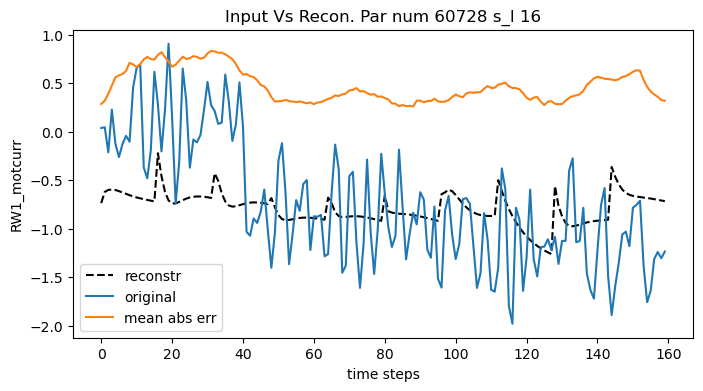

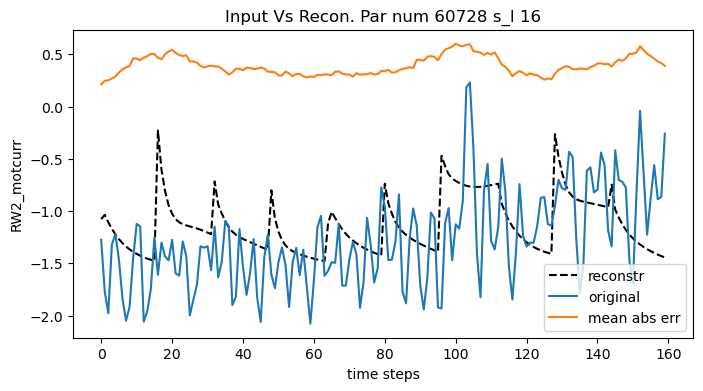

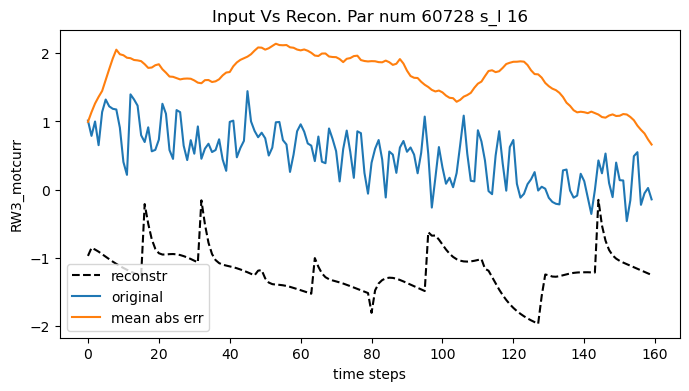

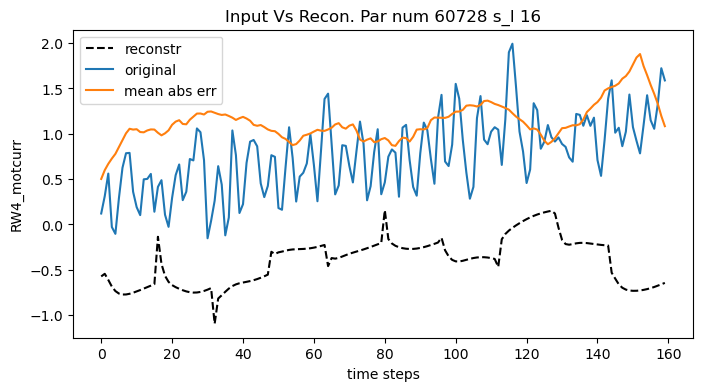

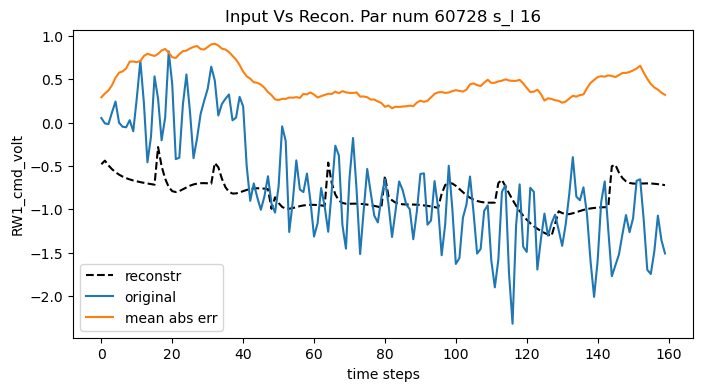

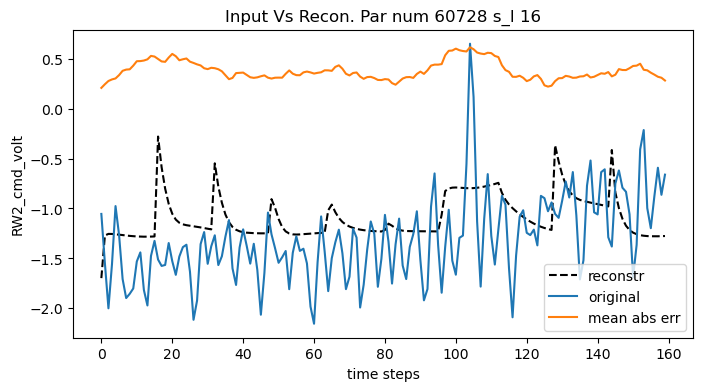

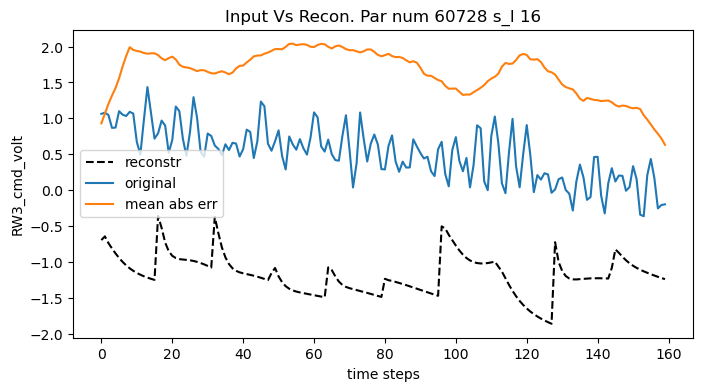

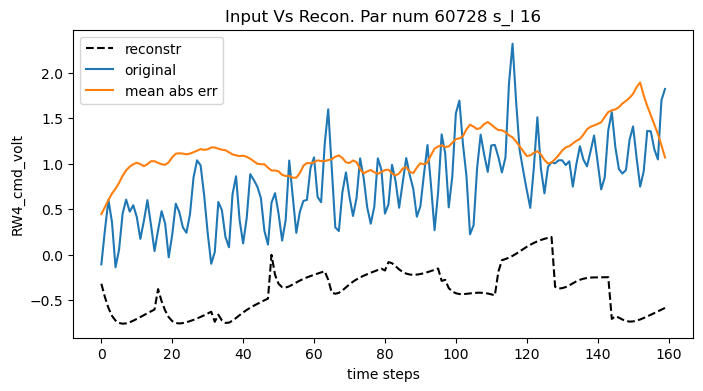

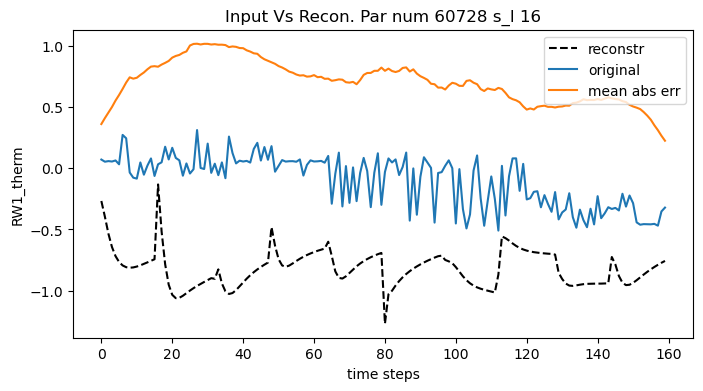

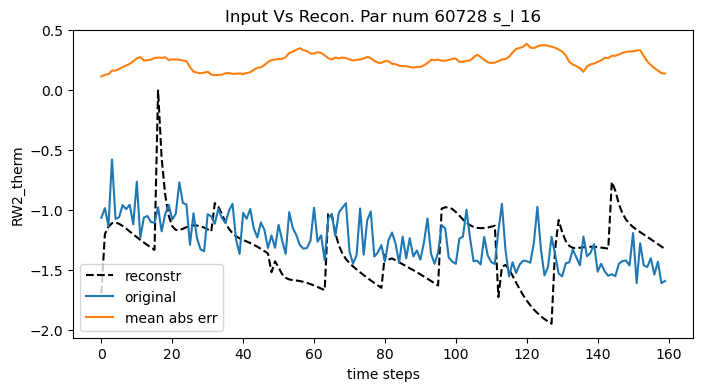

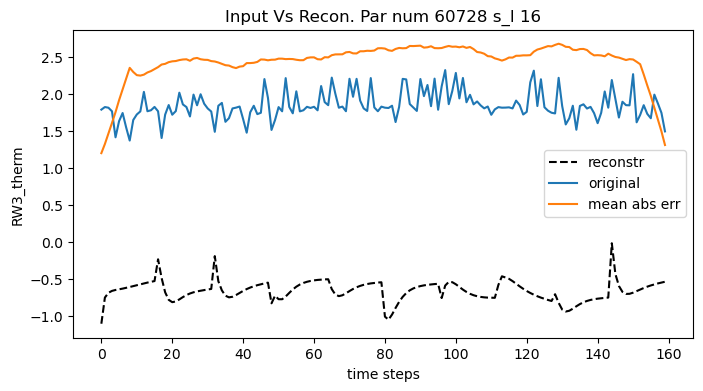

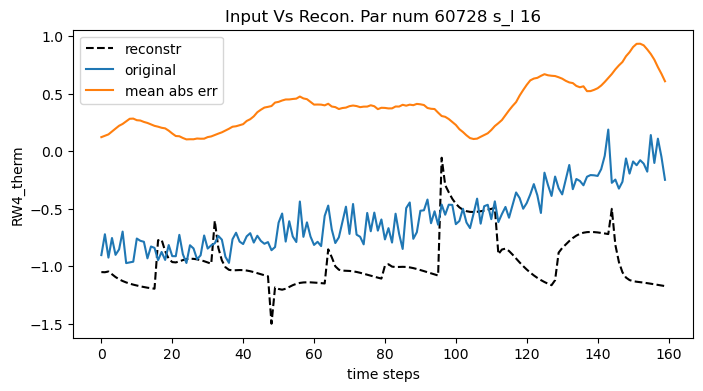

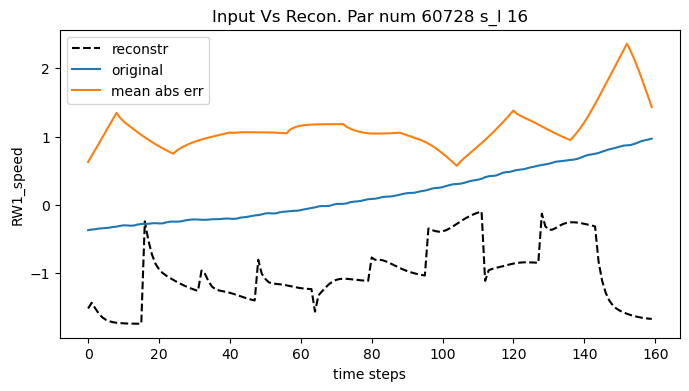

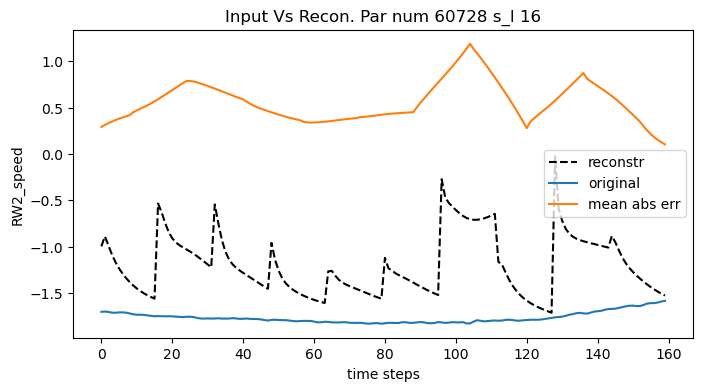

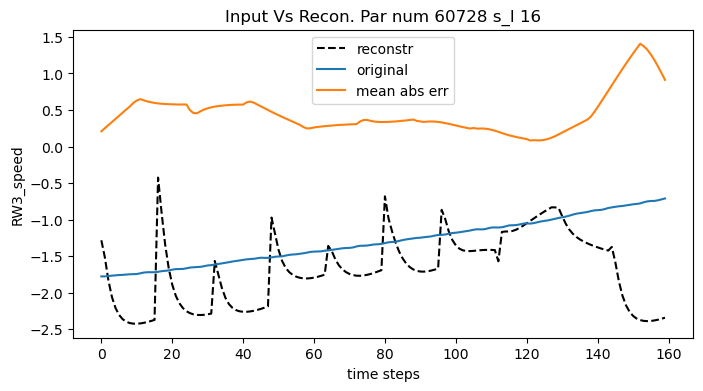

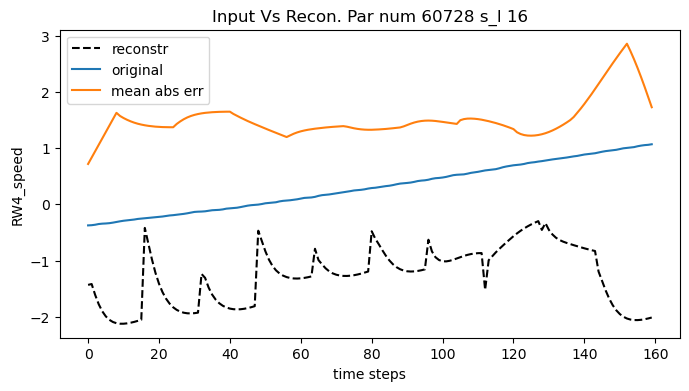

In [28]:
show_results(x, yo, cols, model_name, params_conf
     , par_nums, shift, num_batch,architecture=architecture,save=False)